In [0]:
#!pip install --upgrade tensorflow-gpu==2.1.0rc0 tensorflow==2.1.0rc0

In [2]:
 %tensorflow_version 2.x

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import os
import re
import math

#tf.config.experimental_run_functions_eagerly(True)
print(tf.__version__)

2.1.0-rc1


# ResNet-50 architecture
### Identity Block

In [0]:
# Build the identity block
class IdentityBlock():
  def __init__(self, kernel_size, filters, name, **kwargs):
    '''
      kernel_size: (tuple) size of the filter (kernel)
      filters: number of filters (kernels)
      name: base name for the block
    '''

    self.kernel_size = kernel_size
    self.filters = filters
    self.expansion = 4
    self.name = name

    self.__build()
  
  def __build(self):
    base_name = 'conv'+str(self.name['layer'])+'_block'+str(self.name['inner'])+'_'

    self.conv1 = layers.Conv2D(self.filters, (1, 1), name=base_name+'1_conv')
    self.bn1 = layers.BatchNormalization(name=base_name+'1_bn')
    self.relu1 = layers.Activation('relu', name='activation_'+str(self.name['activation']))

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=base_name+'2_conv')
    self.bn2 = layers.BatchNormalization(name=base_name+'2_bn')
    self.relu2 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 1))

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=base_name+'3_conv')
    self.bn3 = layers.BatchNormalization(name=base_name+'3_bn')
    self.relu3 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 2))


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    x = layers.add([x, input_tensor], name=self.name['merge'])
    return self.relu3(x)

## Convolutional Block

Expands the input depth through a 1x1 convolution to allow the addition with the output of the block

In [0]:
# Build the conv block
class ConvBlock():
  def __init__(self, kernel_size, filters, name, strides=(2, 2), **kwargs):
    '''
      kernel_size: (tuple) size of the filter (kernel)
      filters: number of filters (kernels)
      name: base name for the block
      strides: (tuple) with the size of the stride 
    '''

    self.kernel_size = kernel_size
    self.filters = filters
    self.strides = strides
    self.expansion = 4
    self.name = name
    self.__build()


  def __build(self):
    base_name = 'conv'+str(self.name['layer'])+'_block'+str(self.name['inner'])+'_'

    self.conv1 = layers.Conv2D(self.filters, (1, 1), strides=self.strides, name=base_name+'1_conv')
    self.bn1 = layers.BatchNormalization(name=base_name+'1_bn')
    self.relu1 = layers.Activation('relu', name='activation_'+str(self.name['activation']))

    self.conv2 = layers.Conv2D(self.filters, self.kernel_size, padding='same', name=base_name+'2_conv')
    self.bn2 = layers.BatchNormalization(name=base_name+'2_bn')
    self.relu2 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 1))

    self.conv3 = layers.Conv2D(self.filters*self.expansion, (1, 1), name=base_name+'3_conv')
    self.bn3 = layers.BatchNormalization(name=base_name+'3_bn')
    self.relu3 = layers.Activation('relu', name='activation_'+str(self.name['activation'] + 2))

    self.shortcut_conv = layers.Conv2D(self.filters*self.expansion, (1, 1), strides=self.strides, name=base_name+'0_conv')
    self.shortcut_bn = layers.BatchNormalization(name=base_name+'0_bn')


  def __call__(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)

    shortcut = self.shortcut_conv(input_tensor)
    shortcut = self.shortcut_bn(shortcut)

    x = layers.add([x, shortcut], name=self.name['merge'])
    return self.relu3(x)

## Build the full network

In [0]:
# Build the ResNet
class ResNet():
  def __init__(self, classes=5):
    '''
      classes: number of output classes
    '''
    
    self._layers = []
    self.classes = classes
    
    # According to paper (ResNet-50)
    self.n_layers = [3, 4, 6, 3]
    self.filters = 64

  def __build(self):
    filters = [64, 128, 256, 512]
    
    # for naming purposes
    merge = 1
    activation = 2
    
    # head
    self._layers.append(layers.ZeroPadding2D(padding=(3, 3), name='head_padding1'))
    self._layers.append(layers.Conv2D(self.filters, (7, 7), strides=(2, 2), padding='valid', name='conv1_conv'))
    self._layers.append(layers.BatchNormalization(name='conv1_bn'))
    self._layers.append(layers.Activation('relu', name='activation_1'))
    self._layers.append(layers.ZeroPadding2D(padding=(1, 1), name='head_padding2'))
    self._layers.append(layers.MaxPooling2D((3, 3), strides=(2, 2), name='maxpooling'))

    # blocks
    for i, l in enumerate(self.n_layers):
      for j in range(l):
        name = {
            'layer': i+2,
            'inner': j+1,
            'merge': 'merge_'+str(merge),
            'activation': activation
        }

        if i == 0 and j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], strides=(1, 1), name=name))
        elif j == 0:
          self._layers.append(ConvBlock((3, 3), filters[i], name=name))
        else:
          self._layers.append(IdentityBlock((3, 3), filters[i], name=name))
        
        merge += 1
        activation +=3

    self._layers.append(layers.GlobalAveragePooling2D(name='avg_pool'))
    self._layers.append(layers.Dense(self.classes, activation='softmax', name='fc'))

  def __call__(self, input_tensor):
    self.__build()

    for i, _layer in enumerate(self._layers):
      if i == 0:
        x = _layer(input_tensor)
      else:
        x = _layer(x)

    return keras.Model(input_tensor, x, name='resnet-50')

In [0]:
# function to load the pretrained weights onto the custom model
def transfer_weights(model):
  '''
    model: keras model to transfer the weights (must be resnet-50)
  '''
  
  trained = keras.applications.resnet.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

  for i, layer in enumerate(trained.layers):
    if len(layer.weights) > 0 and layer.name is not 'probs':
      weights = layer.get_weights()
      model.get_layer(layer.name).set_weights(weights)
  
  model.save_weights('/content/drive/My Drive/retina_images/pretrained/resnet50_weights_imagenet_no_dense.h5', overwrite=True)

In [0]:
# generates a model for regression
def generate_model(model=None, classes=5, shape=(512, 512, 3)):
  '''
    model: keras model
    classes: number of output classes
    shape: tuple like shape of the input
  '''
  
  input = keras.Input(shape=shape)
  
  if model is None:
    model = ResNet(classes=classes)(input)

  x = layers.Dense(1, activation='linear')(model.output)

  return keras.Model(model.input, x)

In [0]:
# Display model layers
model = ResNet(classes=5)(keras.Input(shape=(512, 512, 3)))
#transfer_weights(model, f'{DATASET_PATH}pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
#model.load_weights(f'{DATASET_PATH}pretrained/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model.summary()

In [0]:
# Mount the google drive folder with the data
from google.colab import drive

drive.mount('/content/drive')

In [0]:
# Paths of the data
DATASET_PATH    = '/content/drive/My Drive/retina_images/'
CHECKPOINT_PATH = DATASET_PATH + '/checkpoints/'
DATA_SRC_PATH   = DATASET_PATH + '/data/'

TEMP_PATH       = '/content/'
DATA_PATH       = TEMP_PATH + '/data/'

In [0]:
# unzip the .zip files to the local /content/data of the notebook
!unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/train_dst.zip"}'
!unzip -q -n -d '{DATA_PATH}' '{DATASET_PATH+"/test_dst.zip"}'

In [13]:
!dir '{DATA_PATH}/train_dst' | head
!dir '{DATA_PATH}/test_dst' | head

10003_left.jpeg   19968_left.jpeg   30000_left.jpeg   39972_right.jpeg
10003_right.jpeg  19968_right.jpeg  30000_right.jpeg  39975_left.jpeg
10007_left.jpeg   19970_left.jpeg   30004_left.jpeg   39975_right.jpeg
10007_right.jpeg  19970_right.jpeg  30004_right.jpeg  39978_left.jpeg
10009_left.jpeg   19972_left.jpeg   3000_left.jpeg    39978_right.jpeg
10009_right.jpeg  19972_right.jpeg  3000_right.jpeg   39981_left.jpeg
1000_left.jpeg	  19975_left.jpeg   30012_left.jpeg   39981_right.jpeg
1000_right.jpeg   19975_right.jpeg  30012_right.jpeg  39982_left.jpeg
10010_left.jpeg   19976_left.jpeg   30015_left.jpeg   39982_right.jpeg
10010_right.jpeg  19976_right.jpeg  30015_right.jpeg  39983_left.jpeg
10000_left.jpeg   19996_right.jpeg  29928_right.jpeg  39921_right.jpeg
10000_right.jpeg  19997_left.jpeg   29930_left.jpeg   39922_left.jpeg
10001_left.jpeg   19997_right.jpeg  29930_right.jpeg  39922_right.jpeg
10001_right.jpeg  19998_left.jpeg   29931_left.jpeg   39923_left.jpeg
10002_right.jp

In [14]:
!apt-get install libimage-size-perl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libimage-magick-perl
The following NEW packages will be installed:
  libimage-size-perl
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 35.8 kB of archives.
After this operation, 129 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libimage-size-perl all 3.300-1 [35.8 kB]
Fetched 35.8 kB in 0s (116 kB/s)
Selecting previously unselected package libimage-size-perl.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libimage-size-perl_3.300-1_all.deb ...
Unpacking libimage-size-perl (3.300-1) ...
Setting up libimage-size-perl (3.300-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [15]:
!imgsize '/content/data/train_dst/10003_left.jpeg'

width="512" height="512"


## Data preparation

In [14]:
train_labels = pd.read_csv(f'{DATASET_PATH}train_labels.csv')
test_labels = pd.read_csv(f'{DATASET_PATH}test_labels.csv')

classes = [0, 1, 2, 3, 4]

# Remove usage column
test_labels = test_labels.drop('Usage', axis=1)

train_labels['image'] = train_labels['image'].apply(lambda f: f'train_dst/{f}.jpeg')
test_labels['image'] = test_labels['image'].apply(lambda f: f'test_dst/{f}.jpeg')

data = pd.concat([train_labels, test_labels]).sample(frac=1)
data = data.dropna()

data

,image,level
18035,train_dst/22727_right.jpeg,0
17885,test_dst/14865_right.jpeg,0
2946,test_dst/2463_left.jpeg,2
27615,train_dst/34947_right.jpeg,0
44582,test_dst/36845_left.jpeg,1
...,...,...
35229,test_dst/29157_right.jpeg,0
2389,train_dst/2961_right.jpeg,0
17172,test_dst/14265_left.jpeg,0
629,test_dst/546_right.jpeg,0


### Visualization of the number of data per class

([<matplotlib.axis.XTick at 0x7f5230d0c898>,
 <a list of 5 Text xticklabel objects>)

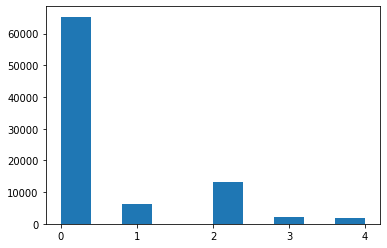

In [15]:
plt.hist(x=data['level'])
plt.xticks(classes)

# Normal training split

In [0]:
data_c0 = data.where(data['level'] == 0).dropna()
data_c0 = data_c0.iloc[:int(len(data_c0) * 0.2)]
data_cP = data.where(data['level'] > 0).dropna()

data = pd.concat([data_c0, data_cP]).sample(frac=1) # concat & shuffle data

split = int(len(data) * 0.1)
test_df = data.iloc[:split].copy()
train_df = data.iloc[split:].copy()

# High definition training split

In [0]:
# newdata = None

# for class_ in classes:
#   values = data.where(data['level'] == class_).dropna() 
#   if class_ == 0:
#     newdata = values.iloc[:int(len(values) * 0.05)]
#   else:
#     newdata = pd.concat([newdata, values.iloc[:int(len(values) * 0.2)]])

# split = int(len(newdata) * 0.1)
# test_df = newdata.iloc[:split].copy()
# train_df = newdata.iloc[split:].copy()

### New distribution for training

([<matplotlib.axis.XTick at 0x7f5230392eb8>,
 <a list of 5 Text xticklabel objects>)

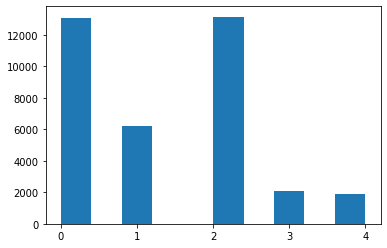

In [17]:
plt.hist(x=data['level'])
plt.xticks(classes)

In [43]:
BATCH_SIZE = 32
IMG_SIZE = 512

datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    rotation_range=360,
    horizontal_flip=True,
    vertical_flip=True)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    batch_size=BATCH_SIZE,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

Found 32707 validated image filenames.
Found 3630 validated image filenames.


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 78 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 12 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
# vanilla imagenet weights
imagenet_weights = f'{DATASET_PATH}pretrained/resnet50_weights_imagenet_no_dense.h5'
# weights of first training
diabetic_regression_weights = f'{DATASET_PATH}checkpoints/resnet50_dense_regression.h5'
# weights of the last training with 384x384 images
checkpoint_path = f'{DATASET_PATH}checkpoints/resnet50_dense_regression_checkpoint_384.h5'
# weights of las training with 512x512 images
checkpoint_high_path = f'{DATASET_PATH}checkpoints/resnet50_dense_regression_checkpoint_512.h5'

# Training for multi label classification

In [0]:
# model = ResNet(classes=5)(keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
# model.load_weights(f'{DATASET_PATH}pretrained/resnet50_weights_imagenet_no_dense.h5')
# model = keras.applications.resnet_v2.ResNet50V2(input_tensor=keras.Input(shape=(384, 384, 3)), weights=None, classes=5)
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=keras.losses.CategoricalCrossentropy(), metrics=[keras.metrics.CategoricalAccuracy()])
# model.fit(train_generator,
#           epochs=10,
#           validation_data=validation_generator,
#           max_queue_size=16,
#           workers=4, use_multiprocessing=False)

# Training for regression

In [0]:
def lr_schedule(epoch, alpha):
  decay = (1 - (epoch / float(10))) ** 1
  alpha = 0.00001 * decay

  return float(alpha)

# Callbacks
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_high_path, verbose=1, save_best_only=True, save_weights_only=True)
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

model = generate_model(None, 5, (IMG_SIZE, IMG_SIZE, 3))
model.load_weights(checkpoint_high_path)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss=keras.losses.MeanSquaredError())
# model.fit(train_generator,
#           epochs=10,
#           validation_data=validation_generator,
#           callbacks=[checkpoint, lr_callback],
#           max_queue_size=16,
#           workers=4, use_multiprocessing=False)

# Evaluation and prediction

In [0]:
def classify(x):
  if x <= 0.8:
    return 0
  elif x > 0.8 and x <= 1.6:
    return 1
  elif x > 1.6 and x <= 2.4:
    return 2
  elif x > 2.4 and x <= 3.2:
    return 3
  elif x > 3.2:
    return 4

In [0]:
def classify05(x):
  if x < 0.5:
      return 0
  elif x < 1.5:
      return 1
  elif x < 2.5:
      return 2
  elif x < 3.5:
      return 3
  return 4

In [47]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col='level',
    class_mode='raw',
    shuffle=False,
    batch_size=BATCH_SIZE*2,
    target_size=(IMG_SIZE, IMG_SIZE),
    directory=DATA_PATH,
    validate_filenames=True)

predictions = []
true_labels = []

for i in range(len(validation_generator)):
  x, true_y = validation_generator[i]
  _predictions = model.predict(x)

  del x

  for j in range(len(_predictions)):
    class_p = int(classify(_predictions[j]))
    class_t = int(true_y[j])
    predictions.append(class_p)
    true_labels.append(class_t)

print(true_labels)
print(predictions)

/tensorflow-2.1.0/python3.6/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 12 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 3630 validated image filenames.
[0, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 2, 0, 3, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 3, 0, 2, 1, 0, 2, 0, 0, 2, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 4, 2, 0, 0, 0, 2, 0, 0, 3, 2, 2, 4, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 2, 2, 0, 3, 0, 4, 0, 2, 0, 2, 4, 1, 0, 2, 2, 1, 1, 2, 0, 1, 0, 3, 2, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 3, 2, 1, 2, 2, 1, 0, 2, 4, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 3, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 3, 2, 2, 0, 2, 0, 2, 2, 2, 1, 0, 4, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 3, 3, 2, 2, 4, 1, 1, 4, 2, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 4, 2, 1, 1, 4, 0, 3, 2, 4, 1, 2, 0, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 4, 2, 0, 1, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2, 2, 4, 2, 0, 1, 2, 0, 3, 0, 0, 1, 0, 4, 1, 0, 2, 3, 2, 0, 2, 0, 1, 2, 2, 4, 2, 0, 0, 0, 2, 0, 1

In [0]:
import sklearn.metrics

sklearn.metrics.cohen_kappa_score(true_labels, predictions, weights='quadratic')